In [8]:
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np
from math import lcm

In [9]:
class Task:
    def __init__(self, execution_time, period, victim_task_id=None, deadline=None, offset=0):
        self.execution_time = execution_time
        self.offset = offset
        self.period = period
        self.deadline = deadline
        self.id = victim_task_id
        self.arrivals = []
    
    def __repr__(self):
        return f"T{self.id}(e={self.execution_time}, p={self.period})"

    def copy(self):
        return Task(self.execution_time, self.period, self.id, self.deadline, self.offset)    

class Schedule:
    def __init__(self, sequence, victim_id=None, attacks=[]):
        self.sequence = sequence
        self.hyperperiod = len(sequence)
        self.victim_id = victim_id
        self.attacks = attacks

    def copy(self):
        return Schedule(self.sequence, self.victim_id, self.attacks)
        
    def __repr__(self):
        return f"Schedule(hyperperiod={self.hyperperiod}{f', victim=T{self.victim_id}, attacks={len(self.attacks)}' * (self.victim_id is not None)})"

In [277]:
def input_tasks(num_tasks):
    task_list = []
    print("Enter `execution time` and `period` in milliseconds (collapse by a SPACE)")
    for i in range(1, num_tasks + 1):
        e, p = map(int, input(f"\tTask {i}: ").strip().split(' '))
        if e > p:
            print('s infeasible ... execution time > period for task', i)
            return None
        task_list.append(Task(e, p, i))
    return task_list

def create_tasks_from_file(filename):
    task_list = []
    with open(filename, 'r') as f:
        for i in range(int(f.readline().strip())):
            e, p = map(int, f.readline().strip().split(' '))
            if e > p:
                print('schedule infeasible ... execution time > period for task', i + 1)
                return []
            task_list.append(Task(e, p, i + 1))
        trusted_task_ids = list(map(int, f.readline().strip().split(' ')))
    return task_list, trusted_task_ids

def edf_scheduler(task_list, verbose=True, randomized=False, dynamic=False):
    if sum([t.execution_time / t.period for t in task_list]) > 1:
        print('Utilisation is greater than one. EDF schedule is INFEASIBLE!')
        return None
    if not dynamic:
        hyperperiod = lcm(*[task.period for task in task_list])
    else:
        hyperperiod = 100
    task_arrivals = [[] for _ in range(hyperperiod)]
    schedule = Schedule([-1] * hyperperiod)
    if verbose:
        print("EDF scheduled for hyperperiod:", hyperperiod, "ms")
    for task in task_list:
        if type(task.period) is int:
            arrivals = np.linspace(0, hyperperiod, hyperperiod // task.period + 1, dtype=int)
        elif type(task.period) is list:
            T = 0 # + task.offset
            arrivals = []
            while T < 100:
                arrivals.append(T)
                T += np.random.choice(task.period)
        if verbose:
            print("\t", task, "arrives at ", arrivals[:-1], "(ms)")
        for i in range(len(arrivals) - 1):
            new_task = task.copy()
            new_task.deadline = arrivals[i + 1]
            task_arrivals[arrivals[i]].append(new_task)
    task_set = []
    for T in range(hyperperiod):
        if randomized:
            np.random.shuffle(task_arrivals[T])
        for arrived_task in task_arrivals[T]:
            task_set.append(arrived_task)    
        curr_task = None
        min_deadline = float("inf")
        for task in task_set:
            if task.execution_time != 0 and task.deadline - T < min_deadline:
                if task.deadline <= T:
                    print('Task {task.id} missed deadline. EDF schedule is INFEASIBLE!')
                    return schedule
                curr_task = task
                min_deadline = task.deadline - T
        if curr_task:
            schedule.sequence[T] = curr_task.id
            curr_task.execution_time -= 1
        else: schedule.sequence[T] = -1
    return schedule

def calculate_all_possibile_schedule(task_list):
    count = 0
    all_schedules = []
    cache = set()
    for _ in range(10000):
        schedule = edf_scheduler(task_list, verbose=False, randomized=True)
        if schedule and tuple(schedule.sequence) not in cache:
            cache.add(tuple(schedule.sequence))
            all_schedules.append(schedule)
            count += 1
    print('Total Possible Schedules: ', len(all_schedules), '\n')
    return all_schedules

def find_potential_attacker_tasks(schedule, victim_task_id, trusted_task_ids):
    if schedule is None or victim_task_id not in trusted_task_ids:
        return [], 'none'
    attacks = []
    t, c = 0, 0
    s = schedule.sequence
    while t < len(s) - 1:
        if s[t] == s[t + 1] or s[t] == -1:
            t += 1
            continue
        if s[t] == victim_task_id and s[t + 1] not in trusted_task_ids + [-1]:
            attacks.append([s[t + 1], t + 1, 'posterior'])
            c += 1
        elif s[t + 1] == victim_task_id and s[t] not in trusted_task_ids + [-1]:
            attacks.append([s[t], t + 1, 'anterior'])
        t += 1
    if len(attacks) > 0:
        if c == 0: attack_type = 'anterior'
        else: 
            if c == len(attacks): attack_type = 'posterior'
            else: attack_type = 'both'
    else: attack_type = 'none'
    attacks.sort()
    return attacks, attack_type

def categorize_all_schedules(task_list, trusted_task_ids, show_summary=True):
    lists = {'anterior': [], 'posterior': [], 'both': [], 'none': []}
    all_schedules = calculate_all_possibile_schedule(task_list)
    for victim_id in trusted_task_ids:
        for schedule in all_schedules:
            attacks, attack_type = find_potential_attacker_tasks(schedule, victim_id, trusted_task_ids)
            lists[attack_type].append(Schedule(schedule.sequence, victim_id, attacks))
    if show_summary:
        for attack_type, schedules in lists.items():
            count = {}
            for schedule in schedules:
                schedule.attacks
                s = f'task {schedule.victim_id}'
                count[s] = count.get(s, 0) + 1
            print(attack_type, " = ", len(schedules), count)
    return lists

def victim_attacker_categorization(task_list, victim_id, attacker_id):
    lists = {'anterior': [], 'posterior': [], 'both': [], 'none': []}
    all_schedules = calculate_all_possibile_schedule(task_list)
    for schedule in all_schedules:
        trusted_task_ids = [task.id for task in task_list if task.id != attacker_id]
        attacks, attack_type = find_potential_attacker_tasks(schedule, victim_id, trusted_task_ids)
        only_attacker = [attack for attack in attacks if attack[0] == attacker_id]
        lists[attack_type].append(Schedule(schedule.sequence, victim_id, only_attacker))
    for attack_type in lists:
        print(attack_type, "=", len(lists[attack_type]))
    return lists

def generate_chart(schedule, task_list, trusted_task_ids=None, attacker_id=None, collapse=False, save_as=None):
    # tasks = sorted(task_list, key=lambda t: t.period)
    n, hyp = max(schedule.sequence), schedule.hyperperiod
    if not collapse:
        fig, axes = plt.subplots(n, 1, figsize=(max(hyp // 10, 5), n * 1.5))
        for task, ax in zip(task_list, axes):
            ax.axis([0, hyp, 0, 2])
            ax.set_yticks([])
            ax.set_ylabel(f'Task {task.id}')
            arrivals = np.linspace(0, hyp, hyp // task.period + 1, dtype=int)
            ax.set_xticks(arrivals)
    else:
        fig = plt.figure(figsize=(max(2 * hyp // n, 6), max(n // 2 + 1, 2)))
        ax = plt.axes()
        ax.axis([0, hyp + max(5, n), 0, max(n - 1, 3)])
        ax.set_yticks([])
        ax.set_xticks(list(range(0, hyp + 1, 5)))

    colors = m.colormaps['plasma'].colors[::255 // n]
    colors.pop(n // 2)
    for i in range(n):
        curr_ax = ax if collapse else axes[i]
        for t, s in enumerate(schedule.sequence):
            if s == i + 1:
                curr_ax.add_patch(m.patches.Rectangle((t, 0), 1, 1, color=colors[i])) 
    title = ''
    if trusted_task_ids is not None:
        title += f" Trusted Task(s): {[i for i in trusted_task_ids]}, "
    if schedule.victim_id is not None:
        title += f" Victim: Task {schedule.victim_id}, "
    if schedule.attacks:
        title += f", Untrusted Task(s): {[i for i in set(s[0] for s in schedule.attacks)]}"
    if attacker_id and attacker_id not in trusted_task_ids:
        title += f", Attacker: Task {attacker_id}"
    plt.title(title, fontsize=18)
    if schedule.attacks:
        text_pos = np.zeros(hyp)
        for i, t, a in schedule.attacks:
            if attacker_id is not None and i != attacker_id:
                continue
            curr_ax = ax if collapse else axes[i - 1]
            print(t, i)
            curr_ax.annotate(text=a, xy=(t, 1), xytext=(t + text_pos[t] * 2 * collapse, \
                2 + text_pos[t] / 3 * collapse), arrowprops = dict(arrowstyle = "->", lw=2, color='r'), fontsize=14 + n)
            text_pos[max(t - 5, 0): t + 5] += 1
        
    if collapse:
        handles = [m.patches.Patch(fc=colors[i], label=f'Task {task_list[i].id}') for i in range(n)]
        plt.legend(loc='lower right', handles=handles, fontsize=18)
    else:
        plt.tight_layout()
    plt.xlabel('time (in milliseconds)', fontsize=14 + n)
    if save_as is not None:
        plt.savefig(save_as)

0.7
Total Possible Schedules:  8 



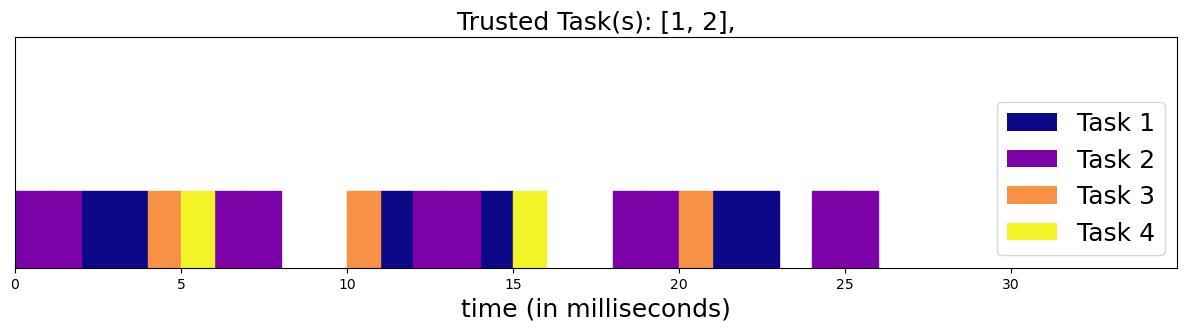

In [284]:
task_list, trusted_task_ids = create_tasks_from_file('input.txt')
print('Utilisation:', sum([t.execution_time / t.period for t in task_list]))
# print("task set: ", task_list)
schedule = edf_scheduler(task_list, randomized=True, verbose=False)
if schedule:
#     attacks, attack_type = find_potential_attacker_tasks(schedule, trusted_task_ids[0], trusted_task_ids)
#     print(f"\npossible attacks for victim task {trusted_task_ids[0]}\n{attacks}")
#     schedule.victim_id = trusted_task_ids[0]
#     schedule.attacks = attacks
#     print('\nCalculating Possibilities ...')
    calculate_all_possibile_schedule(task_list)
    generate_chart(schedule, task_list, trusted_task_ids, collapse=True)

## Schedule Categorisation

In [285]:
anterior, posterior, both, none = categorize_all_schedules(task_list, trusted_task_ids).values()

Total Possible Schedules:  8 

anterior  =  1 {'task 2': 1}
posterior  =  1 {'task 1': 1}
both  =  14 {'task 1': 7, 'task 2': 7}
none  =  0 {}


In [287]:
anterior, posterior, both, none = victim_attacker_categorization(task_list, victim_id=1, attacker_id=4).values()

Total Possible Schedules:  8 

anterior = 0
posterior = 6
both = 0
none = 2


In [275]:
schedules = sorted(both, key=lambda s: len(s.attacks))

4 3
22 3


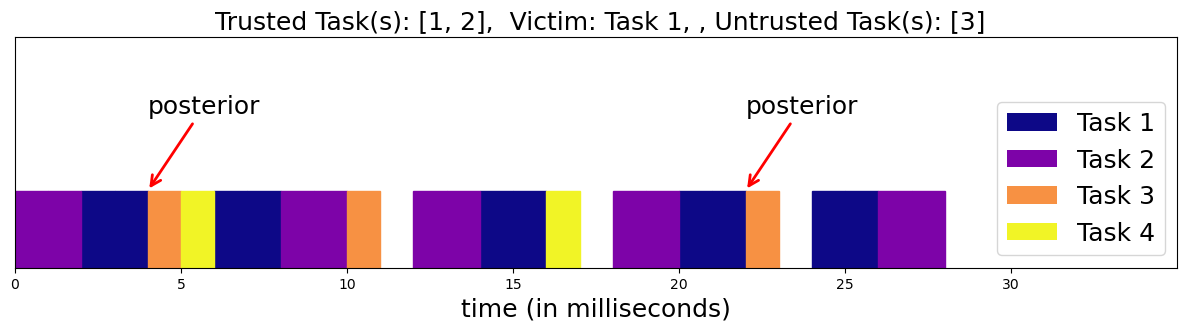

In [276]:
attacker_id = None
generate_chart(schedules[-1], task_list, trusted_task_ids, attacker_id, collapse=True)

In [ ]:
s = schedules[0].copy()

3 3
21 3


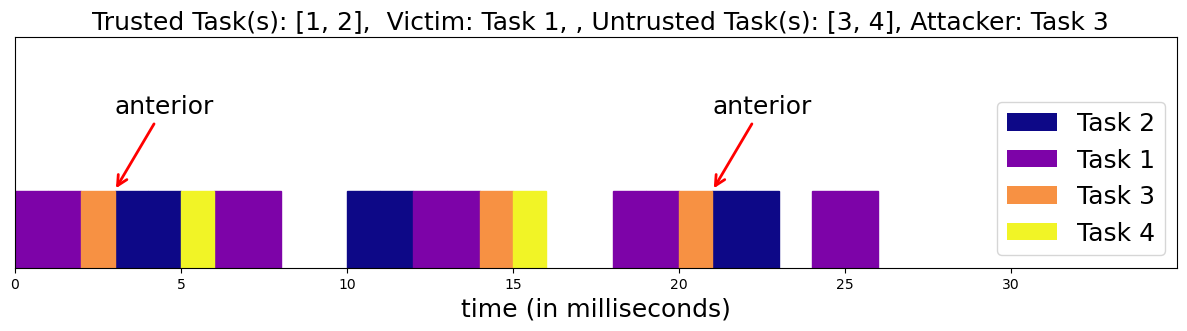

In [134]:
attacker_id = 3
generate_chart(schedules[5], task_list, trusted_task_ids, attacker_id, collapse=True)

In [30]:
s = schedules[0].copy()

Schedule(hyperperiod=30, victim=T1, attacks=1)

10 3


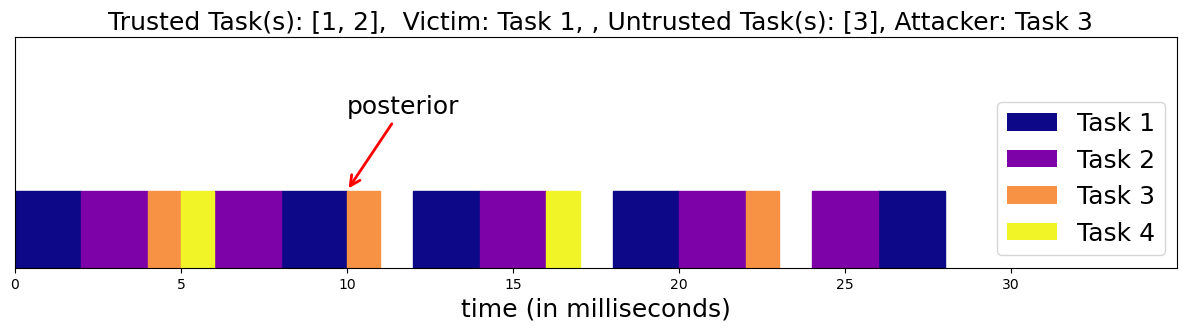

In [145]:
generate_chart(s, task_list, trusted_task_ids, attacker_id, collapse=True)

In [15]:
def concatenate_schedules(schedules):
    sc = Schedule([])
    for schedule in schedules:
        sc.sequence.extend(schedule.sequence)
        sc.hyperperiod += schedule.hyperperiod
    return s

In [8]:
s1 = schedules[0]

In [155]:
dyna_schedule = concatenate_schedules([s, schedules[5]])

10 3
33 3
51 3


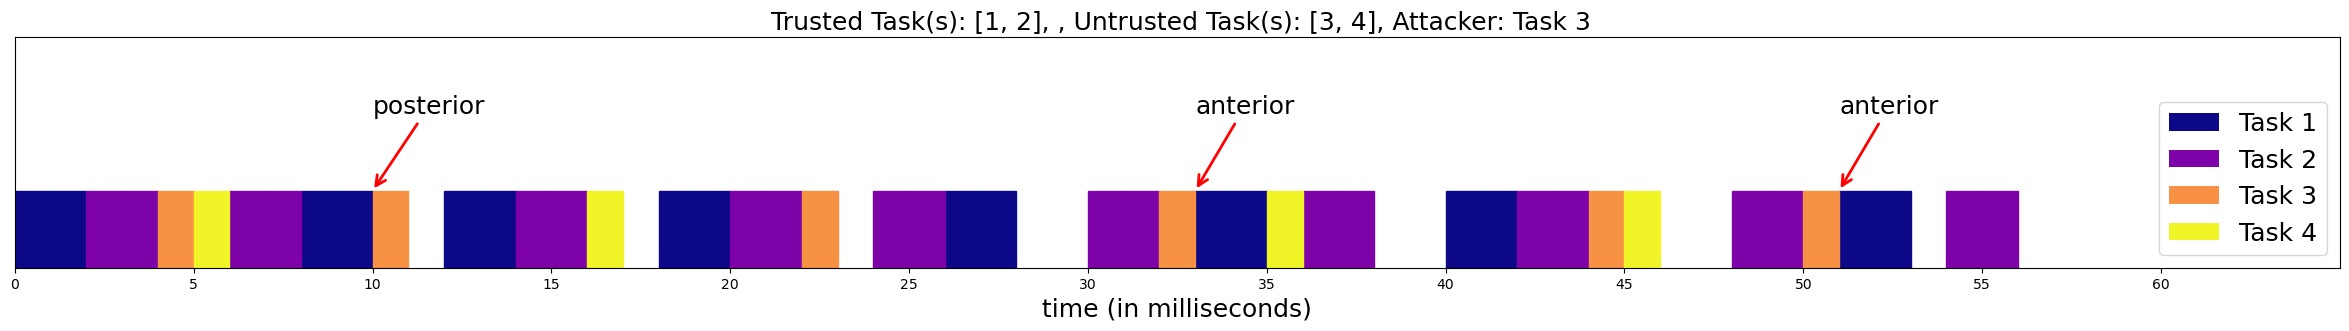

In [167]:
generate_chart(dyna_schedule, task_list, trusted_task_ids, attacker_id, collapse=True)

In [166]:
dyna_schedule.attacks = s.attacks.copy() + [[i, j + 30, k] for i, j, k in schedules[5].attacks]

In [157]:
len(dyna_schedule.sequence)

60

In [ ]:
generate_chart(schedules[28], task_list, trusted_task_ids, attacker_id, collapse=True)

In [ ]:
sequence = static_schedule 

Schedule(hyperperiod=0)

In [ ]:
plt.savefig('static_edf.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
def rank_schedules(schedules):
    for schedule in schedules:
        a = schedule.attacks
        attacker = a[0]
        i, c, m = 1, 0, 0
        while i < len():
            while i < len(a) and a[i] ==  a[i - 1]:
                i += 1
            
            
        attacker = max(tmp, key=tmp.get)

In [ ]:
for s in schedules:
    maxm = 0
    for a in s.attacks:
        while a[1]

2.0